In [19]:
import pandas as pd 
import numpy as np 
import pandas_datareader.data as web
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
symbols =('AAPL', 'MSFT', 'YHOO', 'DB', 'GLD')
data = web.DataReader(symbols,"morningstar",'2018-05-01',"2018-06-22")['Close']

In [41]:
type(data)

pandas.core.frame.DataFrame

In [38]:
type(data.index)

pandas.core.indexes.multi.MultiIndex

In [40]:
data=data.unstack(level=0) ## 이러면 데이터프레임화 

In [42]:
data.head()

Symbol,AAPL,DB,GLD,MSFT,YHOO
Date,,,,,
2018-05-01,169.10,13.59,123.71,95.00,69.89
2018-05-02,176.57,13.63,123.65,93.51,70.21
2018-05-03,176.89,13.63,124.28,94.07,70.38
2018-05-04,183.83,13.78,124.54,95.16,72.71
2018-05-07,185.16,13.78,124.57,96.22,75.33


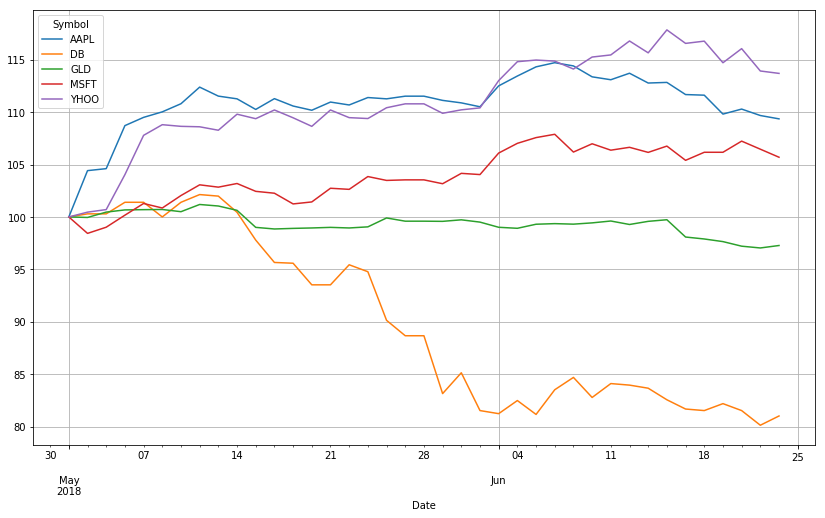

In [43]:
# 여러 주가 데이터 시각화 
(data / data.iloc[0] * 100).plot(figsize=(14,8), grid=True)
plt.show()

In [44]:
rets = np.log(data/data.shift(1)) # shift 일별 수익률 일반적으로 로그 수익률 
rets.mean() * 252

Symbol
AAPL    0.593082
DB     -1.396148
GLD    -0.183158
MSFT    0.367289
YHOO    0.851038
dtype: float64

In [45]:
rets.cov() * 252

Symbol,AAPL,DB,GLD,MSFT,YHOO
Symbol,,,,,
AAPL,0.033876,0.012187,0.003033,0.006513,0.019922
DB,0.012187,0.097212,0.002273,0.006870,0.003060
GLD,0.003033,0.002273,0.005617,0.002164,0.002116
MSFT,0.006513,0.006870,0.002164,0.017864,0.014660
YHOO,0.019922,0.003060,0.002116,0.014660,0.035752


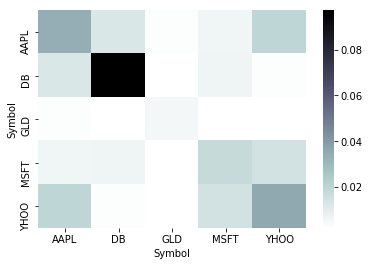

In [46]:
import seaborn as sns
import matplotlib as mpl
sns.heatmap(rets.cov() * 252, cmap=mpl.cm.bone_r)
plt.show()

In [47]:
noa = len(symbols)

In [116]:
np.random.seed(2)
weights = np.random.random(noa)
weights /= np.sum(weights) # weights / np.sum(weights)
weights

array([0.23349275, 0.01388454, 0.2943663 , 0.2331326 , 0.22512381])

In [118]:
np.sum(rets.mean() * weights) * 252

0.34239616071686974

In [121]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights)) # 공분산

0.01063304713188659

In [122]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))) # 표준편차

0.1031166675755505

In [123]:
prets = []
pvols = []
for p in range (2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, 
                        np.dot(rets.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

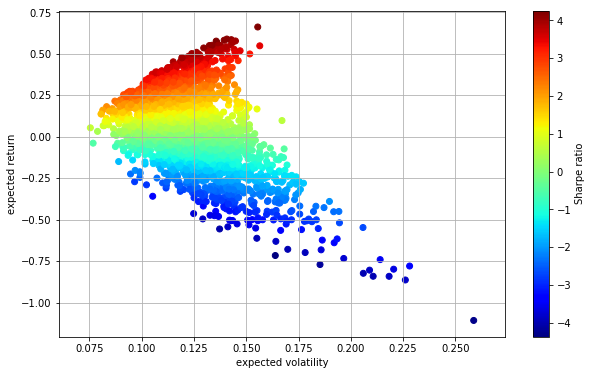

In [126]:
plt.figure(figsize=(10,6))
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap=mpl.cm.jet)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [127]:
def statistics(weights):
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])    

In [128]:
import scipy.optimize as sco

In [129]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [130]:
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

In [131]:
bnds = tuple((0, 1) for x in range(noa))
bnds


((0, 1), (0, 1), (0, 1), (0, 1), (0, 1))

In [132]:
noa * [1. / noa,]

[0.2, 0.2, 0.2, 0.2, 0.2]

In [133]:
%%time
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

Wall time: 44.9 ms


In [134]:
opts

     fun: -4.5760671790026155
     jac: array([ 5.50031662e-04,  9.25939667e+00,  1.48364323e+00, -3.83853912e-04,
       -1.04904175e-04])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([1.95689126e-01, 0.00000000e+00, 2.64306806e-14, 8.32750647e-02,
       7.21035809e-01])

In [136]:
opts['x'].round(3)

array([0.196, 0.   , 0.   , 0.083, 0.721])

In [137]:
statistics(opts['x']).round(3)

array([0.76 , 0.166, 4.576])

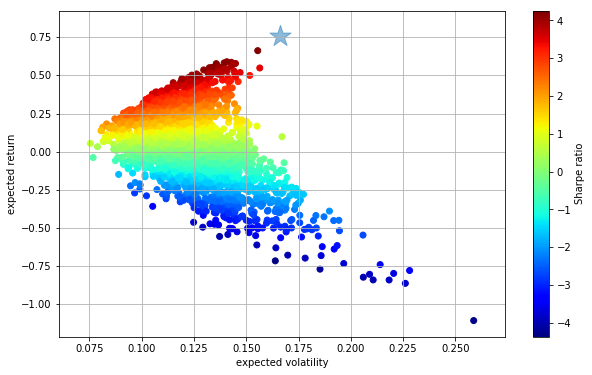

In [139]:
plt.figure(figsize=(10,6))
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap=mpl.cm.jet)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5)
plt.show()
# 샤프 지수 극대화

In [140]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2


In [141]:
optv = sco.minimize(min_func_variance, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

In [142]:
optv

     fun: 0.004912620843097825
     jac: array([0.00990685, 0.00979607, 0.00983223, 0.00976985, 0.00988667])
 message: 'Optimization terminated successfully.'
    nfev: 112
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([0.03595666, 0.01645992, 0.78756925, 0.15223701, 0.00777716])

In [143]:
optv['x'].round(3)


array([0.036, 0.016, 0.788, 0.152, 0.008])

In [144]:
statistics(optv['x']).round(3)


array([-0.083,  0.07 , -1.189])

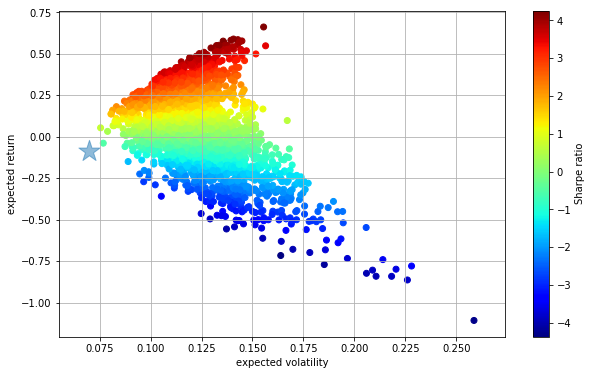

In [145]:
plt.figure(figsize=(10,6))
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap=mpl.cm.jet)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

pt_optv = statistics(optv['x']).round(3)
plt.scatter(pt_optv[1], pt_optv[0], marker="*", s=500, alpha=0.5)
plt.show()

In [146]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [147]:
def min_func_port(weights):
    return statistics(weights)[1]

In [148]:
%%time
trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

Wall time: 3.74 s


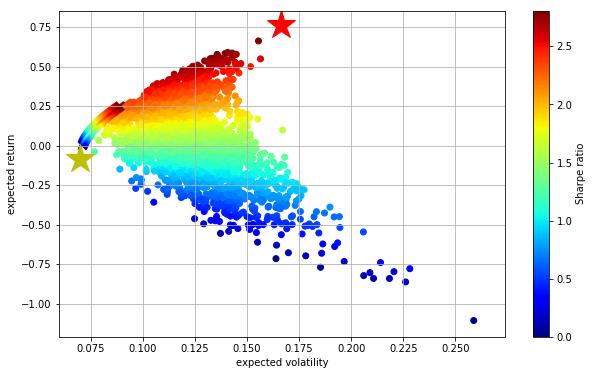

In [150]:
plt.figure(figsize=(10,6))

plt.scatter(pvols, prets,
            c=prets / pvols, marker='o', cmap=mpl.cm.jet)
            # 무작위 포트폴리오
plt.scatter(tvols, trets,
            c=trets / tvols, marker='x', s=70, linewidth=2, cmap=mpl.cm.jet)
            # 효율적 투자선
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=30)
            # 최대 샤프 지수를 가진 포트폴리오
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
         'y*', markersize=30)
            # 최소 분산 포트폴리오
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [151]:
import scipy.interpolate as sci


In [152]:
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]


In [153]:
tck = sci.splrep(evols, erets)

In [154]:
def f(x):
    ''' 효율적 투자선 함수 (스플라인 근사) '''
    return sci.splev(x, tck, der=0)

def df(x):
    ''' 효율적 투자선 함수의 1차 도함수 '''
    return sci.splev(x, tck, der=1)

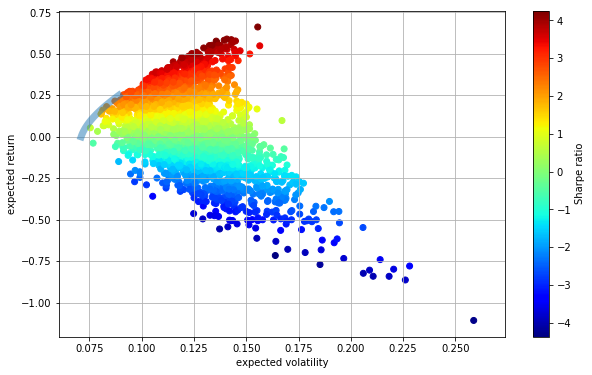

In [155]:
plt.figure(figsize=(10,6))
plt.scatter(pvols, prets,
            c=prets / pvols, marker='o', cmap=mpl.cm.jet)
            # 무작위 포트폴리오

plt.plot(evols, f(evols), lw=7, alpha=0.5)    

plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [162]:
def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

In [163]:
opt = sco.fsolve(equations, [0.01, 1.0, 0.1])
opt

C:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([0.01      , 9.00561967, 0.09124932])

In [164]:
np.round(equations(opt), 6)


array([ 0.      ,  0.561553, -0.051303])

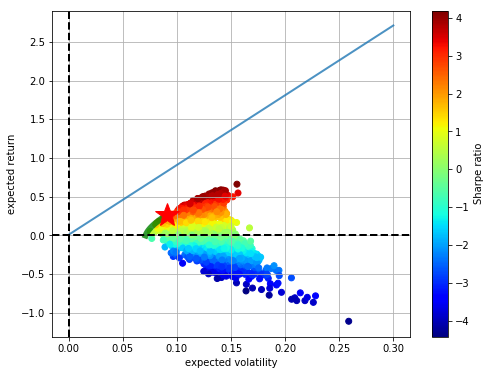

In [165]:
plt.figure(figsize=(8,6))
plt.scatter(pvols, prets,
            c=(prets - 0.01) / pvols, marker='o', cmap=mpl.cm.jet)
            # 무작위 포트폴리오
plt.plot(evols, erets, 'g', lw=6, alpha=0.8)
            # 효율적 투자선
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, lw=2, alpha=0.8)
            # 자본 시장선
plt.plot(opt[2], f(opt[2]), 'r*', markersize=25.0) 
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [166]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - f(opt[2])},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
res['x'].round(3)

array([0.148, 0.   , 0.398, 0.27 , 0.184])

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14,6)
plt.rcParams["axes.grid"] = True

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000019CE8C714E0>,
      dtype=object)

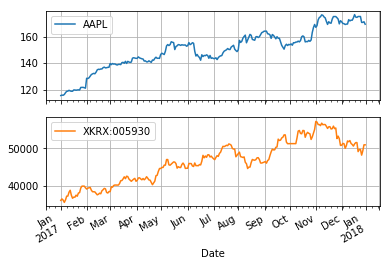

In [10]:
df.unstack(level=0)['Close'].plot(subplots=True)

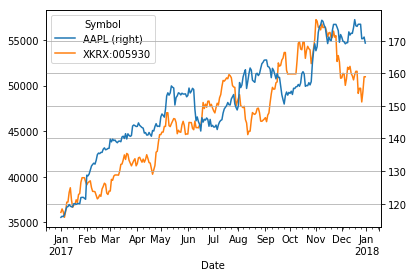

In [11]:
df.unstack(level=0)['Close'].plot(secondary_y='AAPL')

# Numpy

In [1]:
import numpy as np

In [2]:
arr = np.arange(7)

In [3]:
arr

array([0, 1, 2, 3, 4, 5, 6])

In [4]:
arr[2:5]

array([2, 3, 4])

In [5]:
# 2차원 array 
arr2d = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])

In [6]:
arr2d

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16]])

In [7]:
arr2d.dot(arr2d)

array([[ 90, 100, 110, 120],
       [202, 228, 254, 280],
       [314, 356, 398, 440],
       [426, 484, 542, 600]])

In [8]:
arr2d[1,:]

array([5, 6, 7, 8])

In [9]:
dummy = np.random.randn(4,4)

In [10]:
dummy

array([[-1.27397514,  0.58455688,  0.81409466,  0.43933956],
       [-0.47017034, -0.99186196,  0.21277327,  0.36010991],
       [-0.09339103, -0.79251822,  0.08145779,  0.29446073],
       [-0.06070431,  1.02395355, -0.65119344, -1.87423111]])

In [11]:
a = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
idx = np.array([True, False, True, False, True, False, True, False, True, False])
a[idx]

array([0, 2, 4, 6, 8])

In [12]:
a[a % 2 == 0]

array([0, 2, 4, 6, 8])

In [13]:
a = np.array([[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]])
a[a % 2 == 0]

array([0, 2, 4, 6, 8])

In [14]:
a = np.array([0, 1, 2, 3]) * 10
idx = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])
a[idx]

array([ 0,  0,  0,  0,  0,  0, 10, 10, 10, 10, 10, 20, 20, 20, 20, 20])

In [15]:
len(a)

4

In [16]:
len(idx)

16